In [31]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [32]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [33]:
batch_size = 256
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.d = encoded_space_dim
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
        )
        self.encoderMu = nn.Linear(128, self.d)
        self.encoderlogvar = nn.Linear(128, self.d)

        self.decoder = nn.Sequential(
            nn.Linear(self.d, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1),
            nn.Sigmoid()
       )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x_enc = self.encoder1(x)
        mu = self.encoderMu(x_enc)
        logvar = self.encoderlogvar(x_enc)
        z = self.reparameterize(mu,logvar)
        out = self.decoder(z)
        return out, mu, logvar



Using cuda device


In [35]:
latent_dim = 2
model = NeuralNetwork(latent_dim).to(device=device)

In [36]:
def loss_function(x, mu_x, mu_z, logvar_z):
    lnP = torch.nn.functional.mse_loss(x, mu_x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    return lnP + KLD

In [37]:
loss_fn = loss_function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-05)

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred, mu, logvar = model(X)
        loss = loss_fn(X,  pred, mu, logvar)
        epoch_loss += loss.detach().cpu().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return epoch_loss / size

In [39]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred, mu, logvar = model(X)
            test_loss += loss_fn(X, pred, mu, logvar).detach().item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 37812.117188  [    0/60000]
loss: 17340.109375  [25600/60000]
loss: 14717.802734  [51200/60000]
Avg loss: 13456.985857 

Epoch 2
-------------------------------
loss: 13451.765625  [    0/60000]
loss: 12210.005859  [25600/60000]
loss: 12993.586914  [51200/60000]
Avg loss: 12090.999168 

Epoch 3
-------------------------------
loss: 11979.604492  [    0/60000]
loss: 11518.041016  [25600/60000]
loss: 12504.638672  [51200/60000]
Avg loss: 11680.448878 

Epoch 4
-------------------------------
loss: 11578.899414  [    0/60000]
loss: 11185.214844  [25600/60000]
loss: 12098.350586  [51200/60000]
Avg loss: 11335.273596 

Epoch 5
-------------------------------
loss: 11159.579102  [    0/60000]
loss: 10891.827148  [25600/60000]
loss: 11671.760742  [51200/60000]
Avg loss: 11097.981107 

Epoch 6
-------------------------------
loss: 10882.238281  [    0/60000]
loss: 10596.867188  [25600/60000]
loss: 11371.531250  [51200/60000]
Avg loss: 10767.147006 

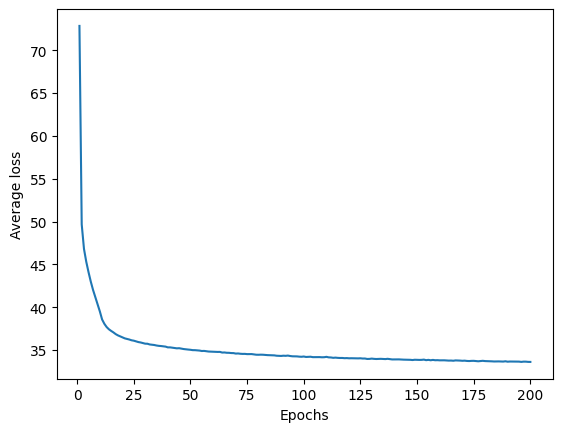

In [40]:
epochs = 200
loss_series = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_loss = train(train_dataloader, model, loss_fn, optimizer)
    loss_series.append(avg_loss)
    test(test_dataloader, model, loss_fn)
print("Done!")
plt.plot(range(1,epochs +1), loss_series)
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.savefig(R"convolutional_VAE_loss.png")

In [53]:
torch.save(model.state_dict(), f"convolutional_VAE.pth")

In [22]:
model = NeuralNetwork(latent_dim).to(device)
model.load_state_dict(torch.load(R"convolutional_VAE.pth"))
model.eval()


NeuralNetwork(
  (encoder1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=288, out_features=128, bias=True)
    (9): ReLU(inplace=True)
  )
  (encoderMu): Linear(in_features=128, out_features=2, bias=True)
  (encoderlogvar): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3

In [14]:
test_dataloader = DataLoader(test_data, batch_size=60000)

In [41]:
def generate_samples(model, batch_size):
    mu = torch.zeros([batch_size, latent_dim], device=device)
    logvar = torch.zeros([batch_size, latent_dim], device=device)
    z = model.reparameterize(mu, logvar)
    img = model.decoder(z)
    return img

def generate_many_samples(model, count, batch_size):
    n_batches = int(count / batch_size) 
    result = torch.zeros(size=(0,1,28,28))
    for i in range(n_batches):
        samples = generate_samples(model, batch_size).detach().cpu()
        result = torch.cat([result, samples], dim = 0)
    return result

many_samples = generate_many_samples(model, 10000, batch_size=100)
np.save(R"convolutional_VAE_samples.npy", many_samples.squeeze().numpy())

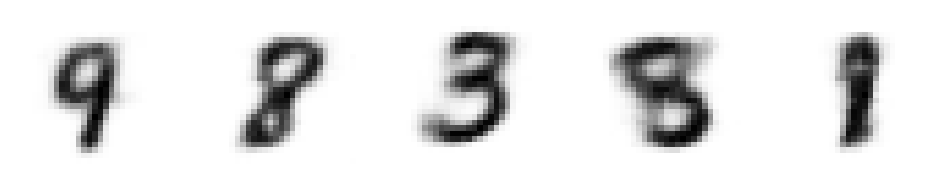

In [38]:
figure = plt.figure(figsize=(12, 2))
cols, rows = 5, 1
for i in range(1,  cols + 1):
    img = many_samples[i]
    img=img.to('cpu').detach().numpy()
    img = img.reshape((1,1,28,28))
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.savefig("convolutional_samples.png")
plt.show()